# LangGraph Development Notebook

This notebook is set up for developing and testing LangGraph components. It includes:
- Environment setup
- Basic graph structure
- Example nodes and tools
- Testing cells

In [24]:
# Import required packages
from dotenv import load_dotenv
import os
from langchain_openai import ChatOpenAI

# Load environment variables
load_dotenv()

# Initialize the LLM
llm = ChatOpenAI(temperature=0)

## Define tools

Define your custom tools here. Each tool should be a function with type hints.

In [25]:
# Create tavily search tool
from langchain_community.tools.tavily_search import TavilySearchResults

# Create tavily search tool with API key from environment
tavily_tool = TavilySearchResults(
    max_results=5,
    api_key=os.getenv("TAVILY_API_KEY")
)

## Define custom state object

Define custom state object for artist profile.

In [26]:
from typing import List, Optional
from langchain_core.messages import BaseMessage
from dataclasses import dataclass

@dataclass
class ArtistState:
    messages: List[BaseMessage]
    artist_website: Optional[str] = None

## Define web search node

Define node to search web for artist using tavily tool.

In [27]:
from langchain_core.messages import AIMessage

def search_artist(state: ArtistState):
    artist_name = state.messages[-1].content
    search_results = tavily_tool.invoke(f"{artist_name} official website")

    formatted_results = "\n".join([
        f"Title: {result['title']}\nURL: {result['url']}\nSnippet: {result['content']}\n"
        for result in search_results
    ])
    return ArtistState(
        messages=[
            AIMessage(
                content=(
                    f"Here are the search results:\n\n"
                    f"{formatted_results}\n\n"
                    f"Which of these appears to be the official website for {artist_name}? "
                    "Please return just the website URL if you find an official website,\n"
                    "or return None if none appear official."
                )
            )
        ]
    )

## Define processing node

A node that processes the web results to return a personal homepage for the band -- or nothing if none of the results are convincing.

In [28]:
def process_search_results(state: ArtistState):
    # Ask LLM to identify official website from results
    llm_response = llm.invoke(state.messages[-1].content)
    
    # Clean up response to get just URL or None
    website = llm_response.content.strip()
    if website.lower() == 'none':
        website = None

    return ArtistState(
        messages=[
            AIMessage(content=f"I've processed the search results and found the following:\n\n{llm_response.content}")
        ],
        artist_website=website
    )

## Create graph structure

Define your graph structure and nodes here.

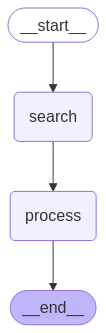

In [29]:

from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Build graph
builder = StateGraph(ArtistState)
builder.add_node("search", search_artist)
builder.add_node("process", process_search_results)

builder.add_edge(START, "search")
builder.add_edge("search", "process")
builder.add_edge("process", END)

graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

## Test the Graph

Test your graph with different inputs and see the results.

In [30]:
from langchain_core.messages import HumanMessage

# Get result from graph
result = graph.invoke(ArtistState(
    messages=[HumanMessage(content="Asaf Yuria Quartet")],
    artist_website=None
))

# Access messages (using dictionary access since it's an AddableValuesDict)
for message in result["messages"]:
    message.pretty_print()

# Access the website
print(f"Artist Website: {result.get('artist_website')}")

================================== Ai Message ==================================

I've processed the search results and found the following:

https://www.asafyuria.com/
Artist Website: https://www.asafyuria.com/


## Debugging Tips

1. Use `%%debug` magic command for step-by-step debugging
2. Print intermediate states
3. Test individual components separately